# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 2

> *Modelo de Clasificación para predecir si el paciente tiene diabetes o no.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [ ]:
# Importar desde Google Drive
!pip install -q gdown

In [ ]:
# Datasets
import gdown
import zipfile

# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualizaciones
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout

### GPU

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye las siguientes variables para cada paciente:
* **Embarazos**: Número de veces embarazada
* **Glucosa**: Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia oral a la glucosa
* **Presión arterial**: Presión arterial diastólica (mm Hg)
* **Espesor de la piel**: Espesor del pliegue cutáneo del tríceps (mm)
* **Insulina**: Insulina sérica a las 2 horas (mu U/ml)
* **IMC**: Índice de masa corporal (peso en kg/(altura en m)^2)
* **Función de pedigree de la diabetes**: Valor que evalúa la probabilidad de diabetes basada en antecedentes familiares.
* **Edad**: Edad (años)
* **Resultado**: variable objetivo (0 para diabetes negativo, 1 para positivo).

### Descarga

In [ ]:
# TP1-2-diabetes.zip
gdown.download('https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_')

Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 13.0MB/s]


'TP1-2-diabetes.zip'

### Descompresión

In [ ]:
with zipfile.ZipFile('TP1-2-diabetes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

### Carga

In [ ]:
# Cargamos el dataset
df = pd.read_csv("TP1-2/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Análisis Exploratorio

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
cols = df.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", df[col].isnull().sum())
    print("Cantidad de valores únicos: ", df[col].nunique())
    print("Tipo de dato: ", df[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if df[col].dtype == "object":
        print("--------------------\n")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if df[col].nunique() < 10:
        print("Valores únicos: ", df[col].unique())
        print("Cantidad de veces que aparece cada valor: ", df[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", df[col].mean())
        print("Desvío estándar: ", df[col].std())
        print("Mínimo: ", df[col].min())
        print("Máximo: ", df[col].max())
    print("--------------------\n")

--------------------
Columna:  Pregnancies
Cantidad de valores nulos:  0
Cantidad de valores únicos:  17
Tipo de dato:  int64
Media:  3.8450520833333335
Desvío estándar:  3.3695780626988694
Mínimo:  0
Máximo:  17
--------------------

--------------------
Columna:  Glucose
Cantidad de valores nulos:  0
Cantidad de valores únicos:  136
Tipo de dato:  int64
Media:  120.89453125
Desvío estándar:  31.97261819513622
Mínimo:  0
Máximo:  199
--------------------

--------------------
Columna:  BloodPressure
Cantidad de valores nulos:  0
Cantidad de valores únicos:  47
Tipo de dato:  int64
Media:  69.10546875
Desvío estándar:  19.355807170644777
Mínimo:  0
Máximo:  122
--------------------

--------------------
Columna:  SkinThickness
Cantidad de valores nulos:  0
Cantidad de valores únicos:  51
Tipo de dato:  int64
Media:  20.536458333333332
Desvío estándar:  15.952217567727637
Mínimo:  0
Máximo:  99
--------------------

--------------------
Columna:  Insulin
Cantidad de valores nulos:  0
Ca

## Conjuntos de Train y Test

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [ ]:
df_train.shape, df_test.shape

((614, 9), (154, 9))

## Procesamiento en Train

En esta sección se define una serie de funciones que ejecutan acciones para prcesar los datos en función de las demandas de las consignas y el gusto personal de los desarrolladores del TP.

La estrategia de emplear funciones permite visibilizar más claramente las acciones aplicadas y facilitar la implementación tanto en el conjunto de entrenamiento como prueba.

### Renombrar Columnas

In [ ]:
def renombrar_columnas(df):
    """
    Renombra las columnas de un DataFrame con nombres abreviados.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df: DataFrame: El DataFrame con las columnas renombradas.
    """
    # Diccionario con los nombres y sus reemplazos
    nuevos_nombres = {
    'BloodPressure': 'Blood',
    'SkinThickness': 'Skin',
    'DiabetesPedigreeFunction': 'Pedigree'
    }
    df.rename(columns=nuevos_nombres, inplace=True)
    return df

In [ ]:
df_train = renombrar_columnas(df_train)

### Filas duplicadas

In [ ]:
duplicadas = df_train.duplicated().any()
print("Hay filas duplicadas.") if duplicadas.any() else print("No hay filas duplicadas.")

No hay filas duplicadas.


In [ ]:
num_duplicados = df_train.duplicated().sum()
num_duplicados

0

In [ ]:
filas_duplicadas = df_train[df_train.duplicated()]
filas_duplicadas

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome


In [ ]:
def eliminar_registros_duplicados(df):
    """
    Elimina los registros duplicados de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que se va a limpiar de registros duplicados.

    Retorna:
    - df_clean: DataFrame: El DataFrame sin registros duplicados.
    """
    df_clean = df.drop_duplicates()
    return df_clean

In [ ]:
df_train = eliminar_registros_duplicados(df_train)

In [ ]:
df_train.shape

(614, 9)

### Recategorización de Variables

(Bloque no usado en esta actividad)

In [ ]:
def recategorizar_variables(df):
    """
    Recategoriza las variable deseadas en un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df_recategorizado: DataFrame: El DataFrame con las variables recategorizadas.
    """
    # df_recategorizado = df.copy()

    # Lista de procedimientos realizados


    return df

In [ ]:
df_train = recategorizar_variables(df_train)

### Normalización Min/Max

In [ ]:
def escalar_datos(df, scaler_dict=None):
    """
    Escala las características en un DataFrame utilizando MinMaxScaler.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna (opcional).

    Retorna:
    - df_scaled: DataFrame: El DataFrame con las características escaladas.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna.
    """
    # Si no se proporciona un diccionario de scalers, inicializar uno
    if scaler_dict is None:
        scaler_dict = {}

    # Iterar sobre cada columna en el DataFrame
    for columna in df.columns:
        # Inicializar un scaler para cada columna si no está en el diccionario
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        # Escalar la columna y reemplazar los valores en el DataFrame
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])

    # Devolver el DataFrame escalado y el diccionario de scalers
    return df, scaler_dict


In [ ]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [ ]:
df_train

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome
318,0.176471,0.577889,0.540984,0.619048,0.188172,0.641414,0.030743,0.116667,0.0
313,0.176471,0.567839,0.409836,0.158730,0.114247,0.496633,0.233988,0.066667,0.0
195,0.294118,0.793970,0.688525,0.650794,0.282258,0.663300,0.135354,0.133333,1.0
570,0.176471,0.391960,0.573770,0.000000,0.000000,0.547138,0.081981,0.300000,0.0
226,0.000000,0.507538,0.622951,0.000000,0.000000,0.601010,0.051238,0.083333,0.0
...,...,...,...,...,...,...,...,...,...
98,0.352941,0.467337,0.409836,0.476190,0.086022,0.483165,0.118702,0.033333,0.0
322,0.000000,0.623116,0.573770,0.317460,0.000000,0.461279,0.075149,0.250000,1.0
382,0.058824,0.547739,0.491803,0.126984,0.244624,0.427609,0.371050,0.000000,0.0
365,0.294118,0.497487,0.442623,0.444444,0.111559,0.572391,0.179761,0.150000,0.0


### Conjuntos X e y

In [ ]:
def separar_Xy(df, target_column):
    """
    Separa las variables explicativas y la variable objetivo de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - target_column: str: El nombre de la columna que se utilizará como variable objetivo.

    Retorna:
    - X: DataFrame: El DataFrame que contiene las variables explicativas.
    - y: DataFrame: El DataFrame que contiene la variable objetivo.
    """
    # Variables explicativas (todas las columnas excepto la columna objetivo)
    X = df.drop([target_column], axis=1).copy()

    # Variable objetivo (solo la columna objetivo)
    y = df[[target_column]].copy()

    return X, y

In [ ]:
X_train, y_train = separar_Xy(df_train, 'Outcome')

In [ ]:
X_train.shape, y_train.shape

((614, 8), (614, 1))

## Visualizaciones

### Histogramas

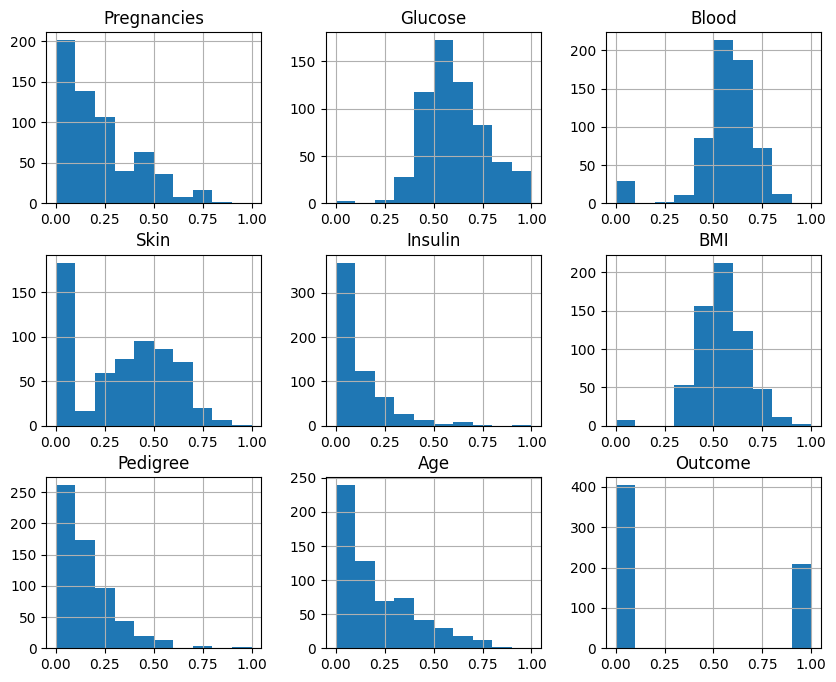

In [ ]:
df_train.hist(figsize=(10,8))
plt.show()

### Boxplot Matrix

In [ ]:
continuous_features = []
for feat in df_train.columns:
    if df_train[feat].nunique() > 2:
        continuous_features.append(feat)

num_cols = 3
num_rows = (len(continuous_features) + 1) // num_cols
fig = make_subplots(rows=num_rows, cols=num_cols)

for i, feature in enumerate(continuous_features):
    row = i // num_cols + 1
    col = i % num_cols + 1

    fig.add_trace(go.Box(x=df_train[feature], name = ' '), row=row, col=col)

    fig.update_yaxes(title_text = ' ', row=row, col=col)
    fig.update_xaxes(title_text= feature, row=row, col=col)
    fig.update_layout(
        title=f'<b>Boxplot Matrix<br> <sup> Continuous Features</sup></b>',
        showlegend=False, yaxis=dict(tickangle=-90)
    )

fig.update_layout(
    height=200 * num_rows,
    width=800,
    margin=dict(t=50, l=50),
    template= 'simple_white'
)
fig.show()

***Observación:*** Se registra una cantidad importante de valores atípicos en algunas características. Su análisis y posible descarte se omite por la indicación de reemplazar esta actividad por la denominada "Problema 2b". Continuamos con el análisis estándar pero sin profundizar en decisiones estratégicas complejas.

### Matriz de Correlación

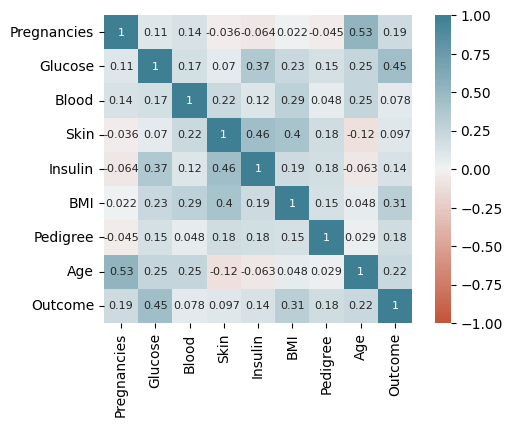

In [ ]:
corr = df_train.corr()

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

### Distribuciones

<Figure size 1200x800 with 0 Axes>

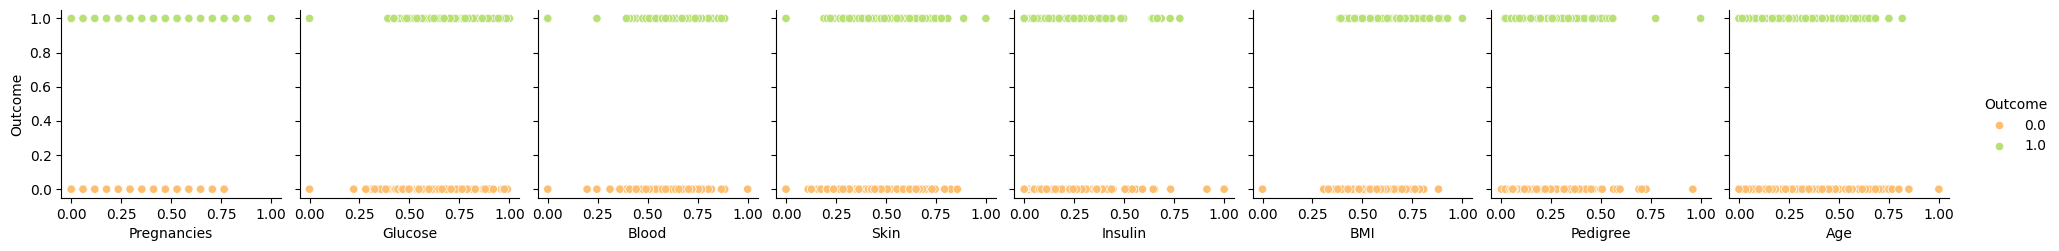

In [ ]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_train, hue='Outcome', x_vars=df_train.drop('Outcome', axis=1).columns, y_vars='Outcome', palette='RdYlGn')
plt.show()

# Red Neuronal / Clasificación

## Procesamiento en Test

In [ ]:
df_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
236,7,181,84,21,192,35.9,0.586,51,1
395,2,127,58,24,275,27.7,1.600,25,0
36,11,138,76,0,0,33.2,0.420,35,0
210,2,81,60,22,0,27.7,0.290,25,0
483,0,84,82,31,125,38.2,0.233,23,0
...,...,...,...,...,...,...,...,...,...
650,1,91,54,25,100,25.2,0.234,23,0
579,2,197,70,99,0,34.7,0.575,62,1
119,4,99,76,15,51,23.2,0.223,21,0
593,2,82,52,22,115,28.5,1.699,25,0


### Pipeline de procesamiento

Se aplica el mismo procesamiento que a los datos de entrenamiento.

In [ ]:
df_out = renombrar_columnas(df_test)
df_out = eliminar_registros_duplicados(df_out)
df_out = recategorizar_variables(df_out)
df_out, _ = escalar_datos(df_out, train_scaler_dict)

In [ ]:
df_out

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome
236,0.500000,0.918782,0.736842,0.212121,0.226950,0.535022,0.226364,0.625000,1.0
395,0.142857,0.644670,0.508772,0.242424,0.325059,0.412817,0.687273,0.083333,0.0
36,0.785714,0.700508,0.666667,0.000000,0.000000,0.494784,0.150909,0.291667,0.0
210,0.142857,0.411168,0.526316,0.222222,0.000000,0.412817,0.091818,0.083333,0.0
483,0.000000,0.426396,0.719298,0.313131,0.147754,0.569300,0.065909,0.041667,0.0
...,...,...,...,...,...,...,...,...,...
650,0.071429,0.461929,0.473684,0.252525,0.118203,0.375559,0.066364,0.041667,0.0
579,0.142857,1.000000,0.614035,1.000000,0.000000,0.517139,0.221364,0.854167,1.0
119,0.285714,0.502538,0.666667,0.151515,0.060284,0.345753,0.061364,0.000000,0.0
593,0.142857,0.416244,0.456140,0.222222,0.135934,0.424739,0.732273,0.083333,0.0


### Conjuntos X e y

In [ ]:
X_test, y_test = separar_Xy(df_out, 'Outcome')

In [ ]:
X_test.shape, y_test.shape

((154, 8), (154, 1))

## Modelo

### Definición y entrenamiento

In [ ]:
# Definición del Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'), Dropout(0.25),
    Dense(16, activation='relu'), Dropout(0.25),
    Dense(1, activation='sigmoid')
])

Este modelo consiste en una capa de entrada seguida de dos capas ocultas, cada una con 16 neuronas y activadas por la función ReLU, con una capa de dropout entre ellas para regularización, y una capa de salida con una sola neurona y activación sigmoide. Este tipo de arquitectura es comúnmente utilizada en problemas de clasificación binaria.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 433 (1.69 KB)
Trainable params: 433 (1.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=1)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
Epoch 1/200
8/8 [==============================] - 1s 43ms/step - loss: 0.7094 - accuracy: 0.3564 - val_loss: 0.6994 - val_accuracy: 0.3659
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.7041 - accuracy: 0.3829 - val_loss: 0.6951 - val_accuracy: 0.3740
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6993 - accuracy: 0.3910 - val_loss: 0.6915 - val_accuracy: 0.5366
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4990 - val_loss: 0.6891 - val_accuracy: 0.6585
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6926 - accuracy: 0.6069 - val_loss: 0.6879 - val_accuracy: 0.6748
Epoch 6/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6893 - accuracy: 0.6253 - val_loss: 0.6867 - val_accuracy: 0.6423
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6866 - accuracy: 0.6456 - val_loss: 0.6857 - val_accuracy: 0.65

### Visualización de Métricas

In [ ]:
# Evaluación del modelo en el conjunto de prueba
predictions_prob = model.predict(X_test)
# Aplicar umbral para obtener etiquetas binarias
threshold = 0.5  # Ajusta el umbral según sea necesario
predictions = (predictions_prob > threshold).astype(int)

5/5 [==============================] - 0s 3ms/step


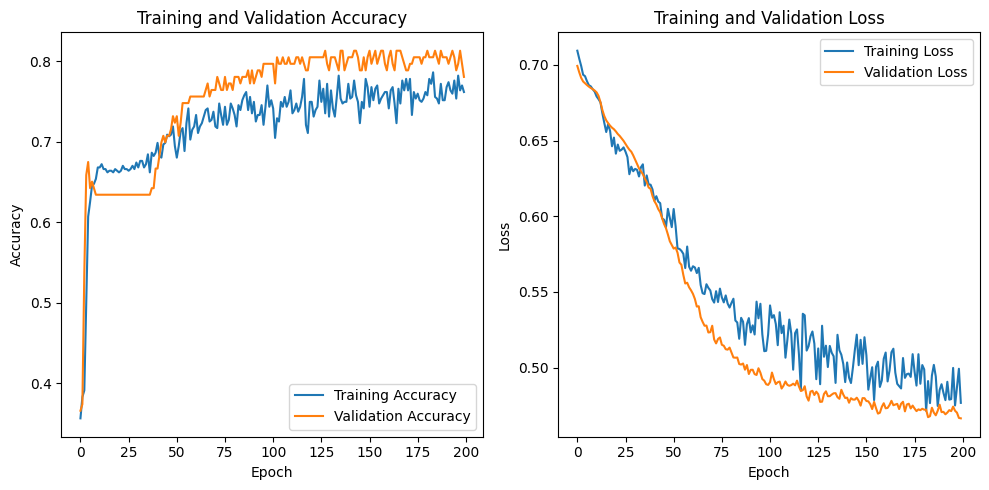

In [ ]:
# Obtener las métricas de precisión y pérdida del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Usar el número de épocas del entrenamiento

plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("--------------------------")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1_score * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

--------------------------
Accuracy: 79.87%
Precision: 80.00%
Recall: 62.07%
F1-Score: 69.90%

Confusion Matrix:
 [[87  9]
 [22 36]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        96
         1.0       0.80      0.62      0.70        58

    accuracy                           0.80       154
   macro avg       0.80      0.76      0.77       154
weighted avg       0.80      0.80      0.79       154



## Predicciones

In [ ]:
# Crear una copia del DataFrame df_test
df_result = df_test.copy()
# Agregar las predicciones al DataFrame resultante
df_result['Pred_Outcome'] = predictions

df_result.head(25)

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome,Pred_Outcome
236,7,181,84,21,192,35.9,0.586,51,1,1
395,2,127,58,24,275,27.7,1.600,25,0,0
36,11,138,76,0,0,33.2,0.420,35,0,1
210,2,81,60,22,0,27.7,0.290,25,0,0
483,0,84,82,31,125,38.2,0.233,23,0,0
743,9,140,94,0,0,32.7,0.734,45,1,1
408,8,197,74,0,0,25.9,1.191,39,1,1
468,8,120,0,0,0,30.0,0.183,38,1,1
283,7,161,86,0,0,30.4,0.165,47,1,1
167,4,120,68,0,0,29.6,0.709,34,0,0


In [ ]:
# Filtrar el DataFrame resultante para obtener solo los registros donde Outcome es igual a 1
df_result_outcome_1 = df_result[df_result['Outcome'] == 1]
df_result_outcome_1

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome,Pred_Outcome
236,7,181,84,21,192,35.9,0.586,51,1,1
743,9,140,94,0,0,32.7,0.734,45,1,1
408,8,197,74,0,0,25.9,1.191,39,1,1
468,8,120,0,0,0,30.0,0.183,38,1,1
283,7,161,86,0,0,30.4,0.165,47,1,1
715,7,187,50,33,392,33.9,0.826,34,1,1
675,6,195,70,0,0,30.9,0.328,31,1,1
254,12,92,62,7,258,27.6,0.926,44,1,0
541,3,128,72,25,190,32.4,0.549,27,1,0
185,7,194,68,28,0,35.9,0.745,41,1,1


# Observaciones finales

Aunque las métricas obtenidas no son del todo malas para el problema de clasificación, los resultados están lejos de ser los deseados para esta situación. Numerosas pruebas y ensayos con distintas configuraciones y arquitecturas motivaron la decisión de reemplazar esta actividad por la denominada "Problema 2b" por lo que se interrumpe la experimentación y se continúa el trabajo con el siguiente.